## Going through the model

In [1]:
import pandas as pd
import json
from pathlib import Path
import sys
import os
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
sys.path.insert(1, os.path.abspath( os.path.dirname("../classes")) )

from classes.model_parameters import StochasticParameters
from classes.facility_parameters import FacilityParameters

In [3]:
data_path = Path(os.path.abspath("")).parent.parent.parent.joinpath("data")

In [4]:
with open(data_path.joinpath("parameters").joinpath("parameters.json"), "r") as f:
    parameters_json_stoch = json.load(f)

with open(data_path.joinpath("facility").joinpath("parameters.json"), "r") as f:
    parameters_json_fac = json.load(f)

gas_forward_curve = pd.read_csv(data_path.joinpath("forward-curve").joinpath("gas-forward-hourly.csv"))
power_forward_curve = pd.read_csv(data_path.joinpath("forward-curve").joinpath("power-forward-hourly.csv"))
parameters = StochasticParameters.from_dict(parameters_json_stoch)
facility_parameters = list(map(lambda d: FacilityParameters.from_dict(d), parameters_json_fac))

g_0 = gas_forward_curve["price"][0]
p_0 = power_forward_curve["price"][0]

In [5]:
parameters

StochasticParameters(sigma_g=0.4, sigma_p=0.5, kappa=50.0, lambda_j=5.0, mu_j=0.5, sigma_j=0.3, rho=0.6, r=0.02)

In [6]:
HOURS_PER_YEAR = gas_forward_curve.index.size
dt = 1 / HOURS_PER_YEAR
dt

0.00011415525114155251

In [7]:
n_samples = 1000

In [8]:
gas_forward_curve.head()

,date,price
0,2025-01-01 00:00:00,3.500000
1,2025-01-01 01:00:00,3.500359
2,2025-01-01 02:00:00,3.500717
3,2025-01-01 03:00:00,3.501076
4,2025-01-01 04:00:00,3.501435


In [9]:
power_forward_curve.head()

,date,price
0,2025-01-01 00:00:00,45.000000
1,2025-01-01 01:00:00,45.007173
2,2025-01-01 02:00:00,45.014345
3,2025-01-01 03:00:00,45.021518
4,2025-01-01 04:00:00,45.028690


### Simulate paths of Power prices and Natural Gas prices

In [10]:
def simulate_paths(n_path: int, dt: float) -> tuple:
    cov_mat = np.array([[1, parameters.rho], [parameters.rho, 1]])
    eps = np.random.multivariate_normal(size=HOURS_PER_YEAR * n_path, mean=np.zeros(2), cov=cov_mat).reshape(HOURS_PER_YEAR, 2, n_path)
    days = np.arange(0, HOURS_PER_YEAR) 
    t_years = np.array(days / len(days))[:, None]

    # Simulate paths for gas curve
    F_g = gas_forward_curve["price"].values[:, None]
    g_paths = F_g * np.exp(-1/2 * parameters.sigma_g ** 2 * t_years + parameters.sigma_g * np.sqrt(dt) * np.cumsum(eps[:, 0, :], axis=0))

    # Simulate paths for power prices 
    F_p = power_forward_curve["price"].values[:, None]
    
    # 1. Prepare Randomness
    dN = np.random.poisson(lam=parameters.lambda_j * dt, size=(HOURS_PER_YEAR, n_path))
    
    # Safety: avoid sqrt(0) warning by using np.maximum (or just ignoring 0s later)
    # The mask (dN > 0) ensures we don't add noise where there is no jump
    dJ = np.random.normal(
            loc=parameters.mu_j * dN, 
            scale=parameters.sigma_j * np.sqrt(np.maximum(dN, 1e-9))
        ) * (dN > 0)

    # 2. Define Compensator (Required for Martingale)
    # E[e^J] - 1
    k_jump = np.exp(parameters.mu_j + 0.5 * parameters.sigma_j**2) - 1
    compensator = parameters.lambda_j * k_jump * dt

    # 3. Simulate Factor X (Arithmetic Loop)
    X_t = np.zeros((HOURS_PER_YEAR, n_path))
    X_t[0, :] = 0.0  # Start at 0, not p_0

    for t in range(HOURS_PER_YEAR - 1):
        # The Arithmetic Update:
        # X_new = X_old + (Mean Reversion) + Diffusion + Jumps - Compensator
        dx = (
            -parameters.kappa * X_t[t] * dt             # Mean Reversion
            + parameters.sigma_p * np.sqrt(dt) * eps[t, 1] # Diffusion
            + dJ[t]                                     # Jump
            - compensator                               # Martingale Correction
        )
        X_t[t + 1] = X_t[t] + dx

    # 4. Construct Price (Geometric Step)
    p_paths = F_p * np.exp(X_t)
    
    return g_paths, p_paths

In [ ]:
g_paths, p_paths = simulate_paths(1_000_000, dt)

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')

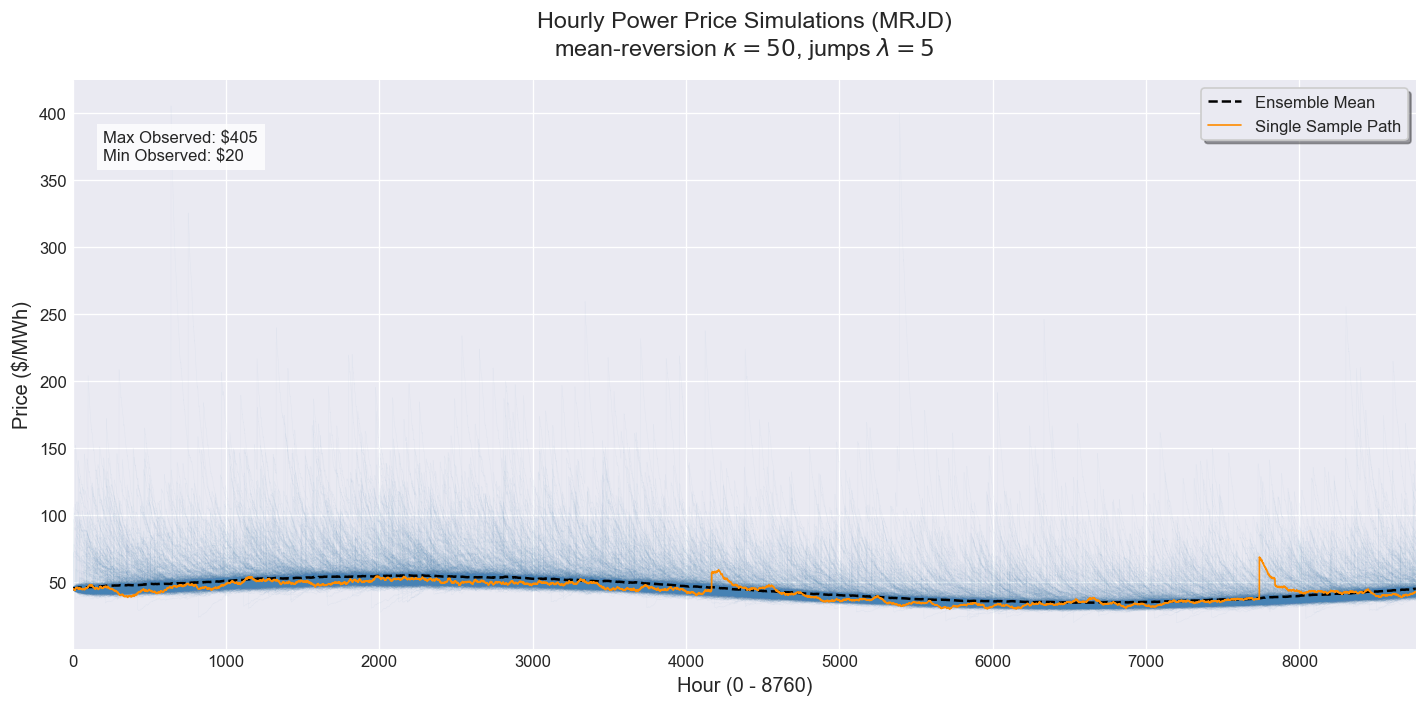

In [ ]:
plt.figure(figsize=(12, 6), dpi=120)

plt.plot(p_paths, color='steelblue', alpha=0.05, linewidth=0.3)

# Plot the Mean (Forward Curve check)
plt.plot(np.mean(p_paths, axis=1), color='black', linewidth=1.5, linestyle='--', label='Ensemble Mean')

# Plot one single realization
plt.plot(p_paths[:, 0], color='darkorange', linewidth=1.0, label='Single Sample Path')

plt.title("Hourly Power Price Simulations (MRJD)\nmean-reversion $\\kappa=50$, jumps $\\lambda=5$", fontsize=14, pad=15)
plt.ylabel("Price ($/MWh)", fontsize=12)
plt.xlabel("Hour (0 - 8760)", fontsize=12)
plt.legend(loc='upper right', frameon=True, framealpha=1, shadow=True)
plt.xlim(0, HOURS_PER_YEAR)

# Add stats box
plt.text(200, np.max(p_paths)*0.9, 
         f"Max Observed: ${np.max(p_paths):.0f}\nMin Observed: ${np.min(p_paths):.0f}", 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()

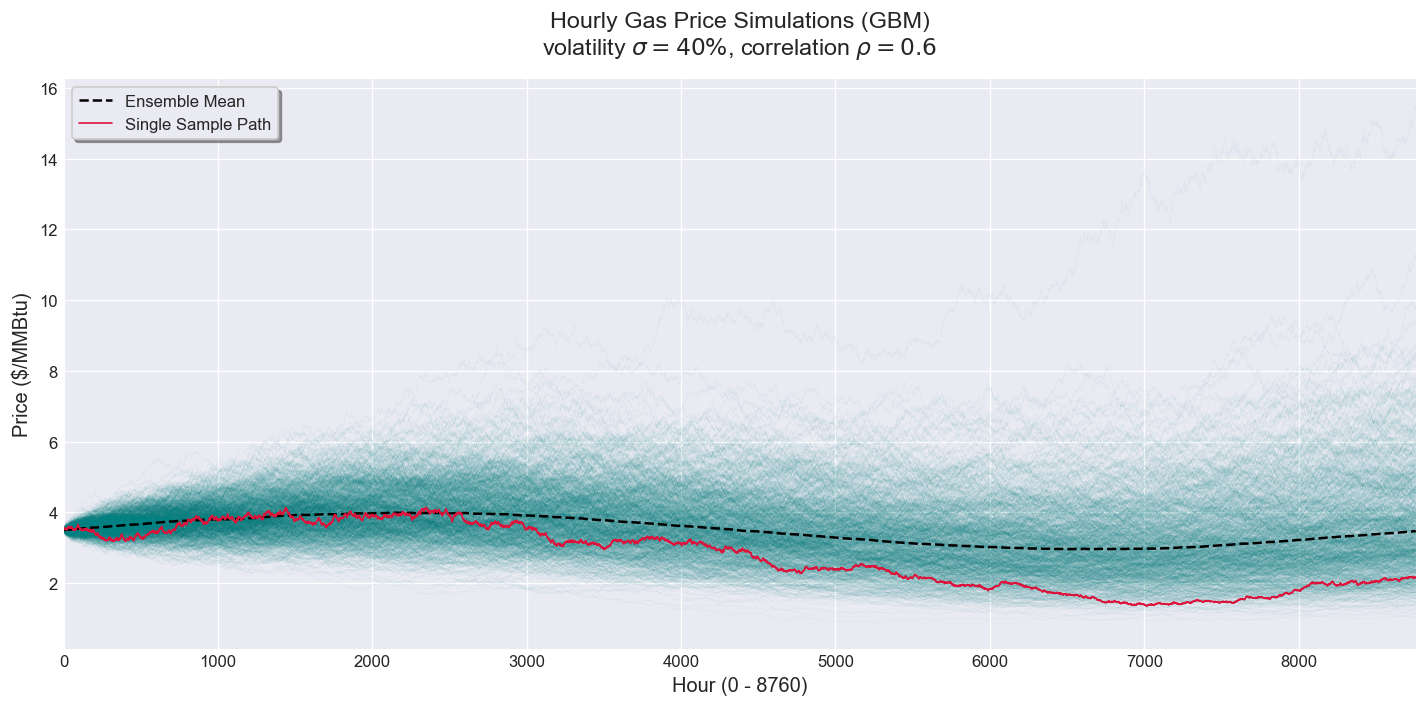

In [ ]:
plt.figure(figsize=(12, 6), dpi=120)

# Background cloud
plt.plot(g_paths, color='teal', alpha=0.05, linewidth=0.3)

# Mean path
plt.plot(np.mean(g_paths, axis=1), color='black', linewidth=1.5, linestyle='--', label='Ensemble Mean')

# Single sample
plt.plot(g_paths[:, 0], color='crimson', linewidth=1.0, label='Single Sample Path')

plt.title("Hourly Gas Price Simulations (GBM)\nvolatility $\\sigma=40\\%$, correlation $\\rho=0.6$", fontsize=14, pad=15)
plt.ylabel("Price ($/MMBtu)", fontsize=12)
plt.xlabel("Hour (0 - 8760)", fontsize=12)
plt.legend(loc='upper left', frameon=True, framealpha=1, shadow=True)
plt.xlim(0, HOURS_PER_YEAR)

plt.tight_layout()
plt.show()

In [ ]:
facility_parameters

[FacilityParameters(heat_rate=1.67, capacity=400, start_up_costs=15000),
 FacilityParameters(heat_rate=3.33, capacity=100, start_up_costs=2000)]

In [ ]:
heat_rates = np.array(list(map(lambda f: f.heat_rate, facility_parameters)))[None, :, None]
capacities = np.array(list(map(lambda f: f.capacity, facility_parameters)))[None, :, None]
start_up_costs = np.array(list(map(lambda f: f.start_up_costs, facility_parameters)))[None, :, None]

g_paths_expanded = g_paths[:, None, :]
pi_not_maxed = p_paths[:, None, :] - g_paths_expanded * heat_rates - start_up_costs
pi = pi_not_maxed * (pi_not_maxed >= 0) * capacities

In [ ]:
# 1. Broadcast parameters correctly
# shapes: (1, N_units, 1)
heat_rates = np.array([f.heat_rate for f in facility_parameters])[None, :, None]
capacities = np.array([f.capacity for f in facility_parameters])[None, :, None]
start_costs = np.array([f.start_up_costs for f in facility_parameters])[None, :, None]

# 2. Expand paths to align with units
# p_paths shape: (8760, N_paths) -> (8760, 1, N_paths)
P = p_paths[:, None, :]
G = g_paths[:, None, :]

# 3. Calculate HOURLY Gross Margin (Operating Cashflow)
# Gross Profit ($) = max(Spread, 0) * Capacity
pi = (P - (G * heat_rates)) * capacities

# 4. Aggregation: Reshape to (365 Days, 24 Hours, N_units, N_paths)
# This assumes your 8760 rows are perfectly 365 days * 24 hours
daily_shape = (365, 24, pi.shape[1], pi.shape[2])
hourly_gross_reshaped = pi.reshape(daily_shape)

# Sum across axis 1 (the 24 hours) to get Total Daily Gross Profit
daily_gross_profit = hourly_gross_reshaped.sum(axis=1)

# 5. Apply Start Cost Logic (The "Option")
# We only pay the start cost if the Daily Profit > Start Cost
# Payoff = max(Daily_Gross - Start_Cost, 0)
daily_net_profit = np.maximum(daily_gross_profit - start_costs, 0)

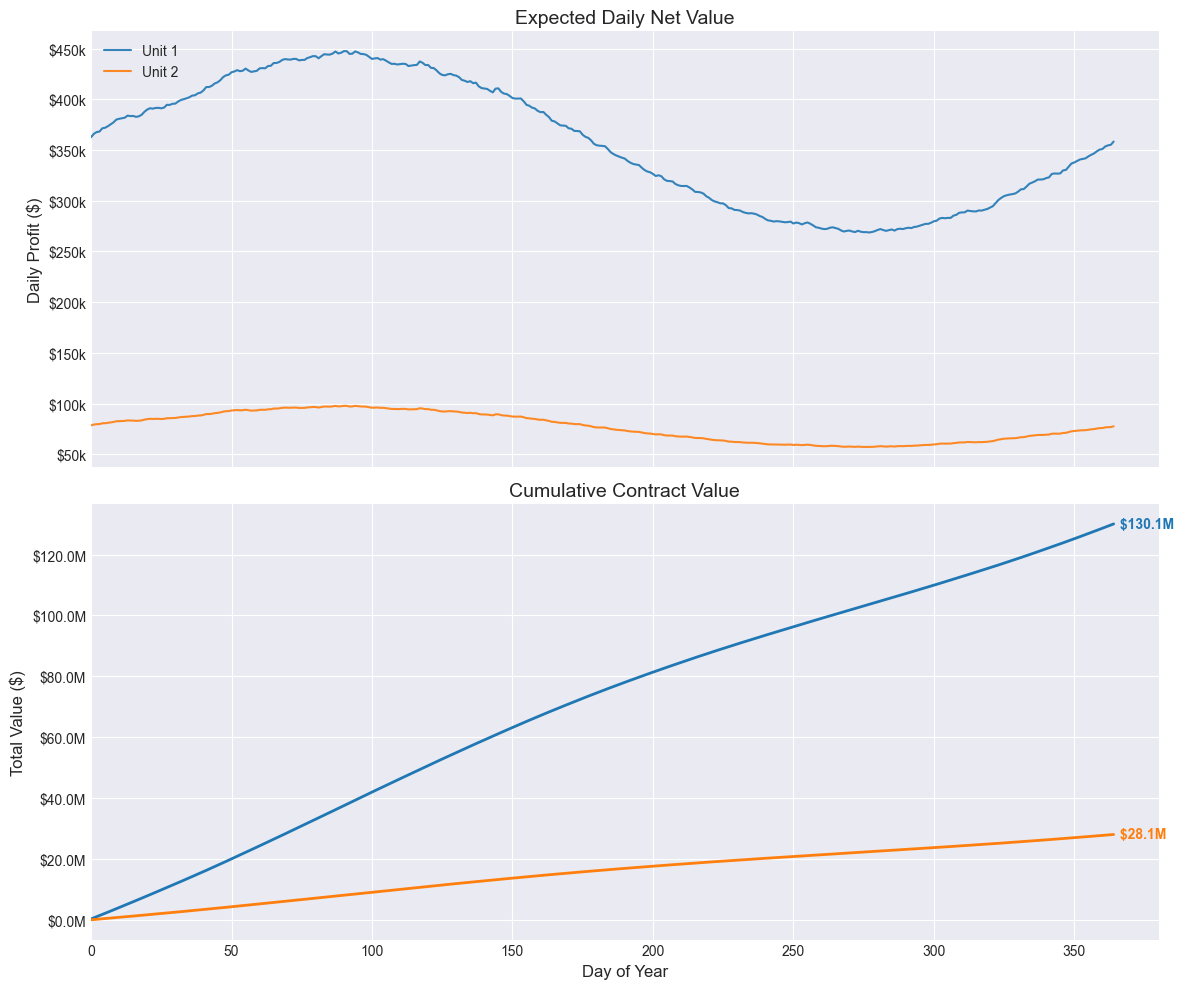

In [ ]:
expected_daily_value = daily_net_profit.mean(axis=2)  # Shape: (365, 2)
cumulative_value = np.cumsum(expected_daily_value, axis=0) # Shape: (365, 2)

# ==========================================
# 2. Plotting
# ==========================================
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Define colors for consistency
colors = ['tab:blue', 'tab:orange']
labels = ['Unit 1', 'Unit 2']

# --- Plot 1: Daily Expected Profit ---
for i in range(2):
    ax1.plot(expected_daily_value[:, i], label=labels[i], color=colors[i], linewidth=1.5, alpha=0.9)

ax1.set_title("Expected Daily Net Value", fontsize=14)
ax1.set_ylabel("Daily Profit ($)", fontsize=12)
ax1.legend(loc="upper left")
# Format Y-axis to $K (thousands)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))

# --- Plot 2: Cumulative Profit ---
for i in range(2):
    ax2.plot(cumulative_value[:, i], label=f"Cumulative: {labels[i]}", color=colors[i], linewidth=2)
    
    # Label the final dollar value at the end of the line
    final_val = cumulative_value[-1, i]
    ax2.text(365, final_val, f" ${final_val/1000000:.1f}M", 
             color=colors[i], fontweight='bold', va='center')

ax2.set_title("Cumulative Contract Value", fontsize=14)
ax2.set_ylabel("Total Value ($)", fontsize=12)
ax2.set_xlabel("Day of Year", fontsize=12)
# Format Y-axis to $M (millions)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1000000:.1f}M'))
ax2.set_xlim(0, 380) # Add space for text labels

plt.tight_layout()
plt.show()

In [ ]:
days = 365

# 1. Create a time vector in YEARS (from t=1/365 to t=1.0)
# Day 1 happens at t=1/365, Day 365 happens at t=1.0
t_years = np.arange(1, days + 1) / 365.0

# 2. Calculate Discount Factors
discount_factors = np.exp(-parameters.r * t_years)

# 3. Apply: Average over paths -> Sum over units -> Discount -> Sum over days
contract_value = (discount_factors * daily_net_profit.mean(axis=2).sum(axis=1)).sum()

print(f"Total Value: {contract_value:,.2f}€".replace(",", "."))

Total Value: 156.698.812.13€
